In [1]:
# --- Imports
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# --- Settings
sns.set_theme(style='whitegrid')
np.random.seed(3)

Creating the data

In [2]:
# Make data
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)

# we turn our (100, 100)-arrays into (10000,)-arrays
x = x.ravel()
y = y.ravel()


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

k = 0.1 # noise coefficient
z = FrankeFunction(x,y)  + k*np.random.randn(n**2) # target variable with standard normal noise


X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

### Ridge

The code below is inspired by and partially reuses code from the Jupyter notebook: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter3.html#introduction

In [10]:
np.random.seed(3)

logmin, logmax, m = -4, 1, 6 # logspce start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)
degrees = list(range(1,6))

k = 10
k_folds = KFold(n_splits=k)
estimated_mse_OLS = np.zeros(len(degrees))
estimated_mse_Ridge = np.zeros((len(degrees), m))
estimated_mse_Lasso = np.zeros((len(degrees), m))

for deg in degrees:
    pipeline_OLS = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler(),
            LinearRegression()
            )
    
    estimated_mse_folds_OLS = cross_val_score(estimator=pipeline_OLS, 
                                              X=X_train, 
                                              y=z_train, 
                                              scoring='neg_mean_squared_error', 
                                              cv=k_folds)
    
    estimated_mse_OLS[deg-1] = np.mean(abs(estimated_mse_folds_OLS))


    for idx, lmb in enumerate(llambdas):
        pipeline_Ridge = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler(),
            Ridge(alpha = lmb)
            )
        
        estimated_mse_folds_Ridge = cross_val_score(estimator=pipeline_Ridge, 
                                              X=X_train, 
                                              y=z_train, 
                                              scoring='neg_mean_squared_error', 
                                              cv=k_folds)

        # take abs() since we score using 'neg_mean_squared_error' and take the mean of all the folds
        estimated_mse_Ridge[deg-1, idx] = np.mean(abs(estimated_mse_folds_Ridge))

        pipeline_Lasso = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler(),
            Lasso(alpha = lmb)
            )
        
        estimated_mse_folds_Lasso = cross_val_score(estimator=pipeline_Ridge, 
                                              X=X_train, 
                                              y=z_train, 
                                              scoring='neg_mean_squared_error', 
                                              cv=k_folds)

        # take abs() since we score using 'neg_mean_squared_error' and take the mean of all the folds
        estimated_mse_Lasso[deg-1, idx] = np.mean(abs(estimated_mse_folds_Lasso))

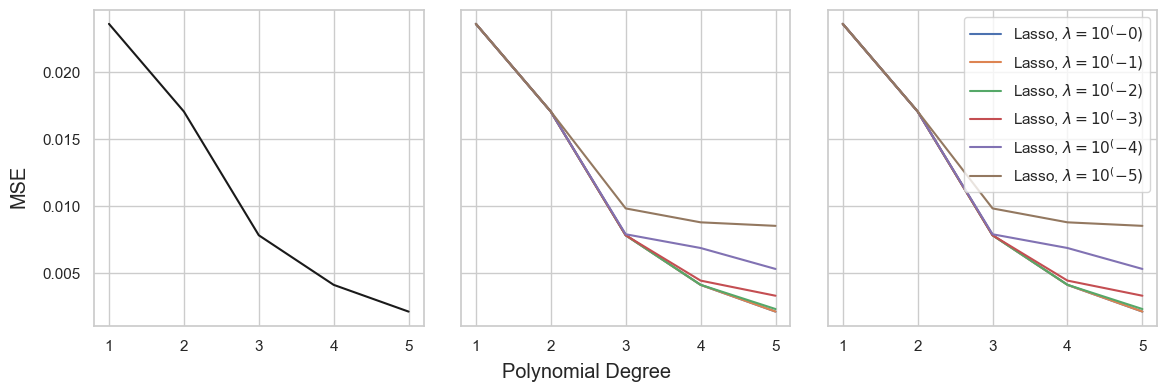

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
fig.tight_layout()

axs[0].plot(degrees, estimated_mse_OLS, label='OLS', color = 'k')

for i in range(len(llambdas)):
    axs[1].plot(degrees, estimated_mse_Ridge[:, i], label=rf'Ridge, $\lambda = 10^(-{i})$')
    axs[2].plot(degrees, estimated_mse_Lasso[:, i], label=rf'Lasso, $\lambda = 10^(-{i})$')

plt.legend()
fig.supxlabel('Polynomial Degree')
fig.supylabel('MSE')

plt.subplots_adjust(left=0.09, bottom=0.15)
plt.show()

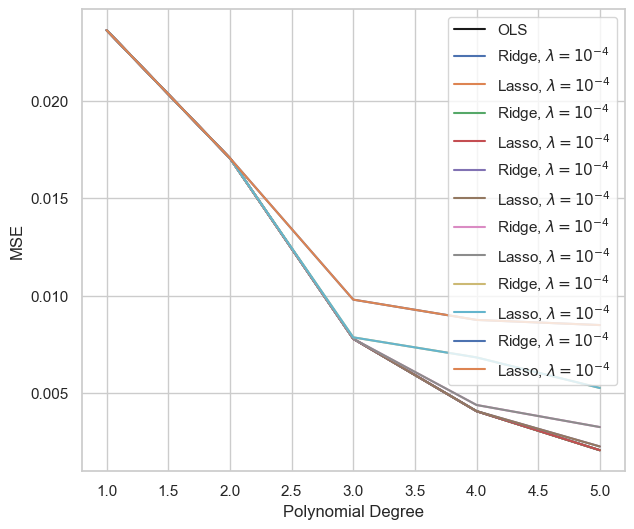

In [11]:
plt.figure(figsize=(7,6))
plt.plot(degrees, estimated_mse_OLS, label='OLS', color = 'k')
for i in range(len(llambdas)):
    plt.plot(degrees, estimated_mse_Ridge[:, i], label=r'Ridge, $\lambda = 10^{-4}$')
    plt.plot(degrees, estimated_mse_Lasso[:, i], label=r'Lasso, $\lambda = 10^{-4}$')

plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.show()

## Grid Search

In [3]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
     ('lasso', Lasso())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'lasso__alpha': np.logspace(-4, 2, 6)}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=10,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

0.008355048365146864
{'lasso__alpha': 0.0001, 'poly__degree': 3}


c:\Users\maria\anaconda3\envs\fysstk3155\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.438e+00, tolerance: 6.603e-02
  model = cd_fast.enet_coordinate_descent(


In [15]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
     ('ridge', Ridge())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': np.logspace(-4, 2, 6)}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=10,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

0.002089017250149556
{'poly__degree': 5, 'ridge__alpha': 0.0001}


In [16]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
     ('linearregressor', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=10,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

0.0020757661387394563
{'poly__degree': 5}
